In [1]:
import sagemaker
from sagemaker import ModelPackage
from time import gmtime, strftime
from sagemaker.predictor import Predictor
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer
import cv2
import numpy as np
import json
import sys
import matplotlib.pyplot as plt

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


##  Create realtime sagemaker endpoint

In [ ]:
sagemaker_session=sagemaker.Session(default_bucket="sagemaker-us-east-1-470086202700")

In [ ]:
# Use the model package arn from the previous notebook of Register Model. End point name is the name of the endpoint you want to create
endpoint_name="balloon-segmentation-test"
model_package_arn="arn:aws:sagemaker:us-east-1:xxxxxx:model-package/balloon-segemntation-nonprod-group/2


In [ ]:
# Create a model from the model package
model = ModelPackage(role=role, 
                     model_package_arn=model_package_arn, 
                     sagemaker_session=sagemaker_session)
# Deploy the model to an endpoint
endpoint_response=model.deploy(initial_instance_count=1, instance_type="ml.p3.2xlarge",endpoint_name=endpoint_name)

In [ ]:
model.endpoint_name

## Use the endpoint name from the previous step

In [2]:
endpoint_name="balloon-segmentation-test"
seg_predictor = Predictor(endpoint_name=endpoint_name, sagemaker_session=sagemaker.Session(),serializer=JSONSerializer(),
    deserializer=JSONDeserializer())
#predictor = Predictor(endpoint_name=endpoint_name, sagemaker_session=sagemaker.Session())

In [29]:
image_path="test_balloon.jpg"
img=cv2.imread(image_path)
print(f"Original image shape is {img.shape}")
img=cv2.resize(img,(int(img.shape[1]),int(img.shape[0])))
if img is None:
    raise("Image cannot be loaded")
img.shape

Original image shape is (1024, 683, 3)


(1024, 683, 3)

In [30]:
f"Image size is {(img.nbytes)/(1024*1024)}MB"

'Image size is 2.0009765625MB'

In [31]:
1024*1024

1048576

Text(0.5, 1.0, 'Input Image')

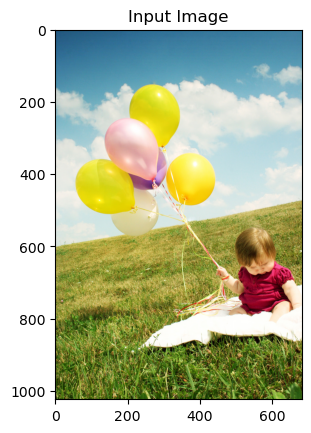

In [32]:
plt.imshow(img[...,::-1])
plt.title("Input Image")

In [33]:
data={"images":img.tolist(),"batch_size":1}

In [34]:
res=seg_predictor.predict(data)

In [35]:
res.keys()

dict_keys(['masks', 'boxes', 'classes', 'scores', 'mask_shape'])

In [36]:
def rle_decode(rle, shape):
    rle = np.array(rle).reshape(-1, 2)
    run_lengths = rle[:, 0]
    run_values = rle[:, 1]
    pixels = np.repeat(run_values, run_lengths)
    return pixels.reshape(shape)

In [37]:
#import numpy as np
rle_masks=res["masks"]
masks_shape= res["mask_shape"]
masks=np.array([rle_decode(rle,masks_shape) for rle in rle_masks ])
boxes=np.array(res["boxes"])
classes=np.array(res["classes"])

In [38]:
np.unique(masks),boxes.dtype,classes

(array([0, 1]), dtype('float64'), array([0, 0, 0, 0, 0, 0, 0]))

In [39]:
def visualize_masks(masks,img):
    """Apply the masks to the image."""
    vis_img=img.copy()
    from random import randint
    for i in range(masks.shape[0]):
        color = [randint(0, 255) for p in range(3)]
        for j in range(3):
            vis_img[:, :,j] = np.where(masks[i] != 0,color[j],vis_img[:,:,j])
    return vis_img

In [15]:
detected_masks=visualize_masks(masks,img)

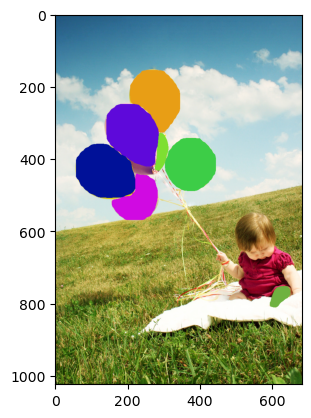

In [16]:
plt.imshow(detected_masks[...,::-1])